In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [37]:
# Loading the data
df = pd.read_csv("/kaggle/input/heart-dataset1/dataset.csv")

In [38]:
# One-hot encoding
df = pd.get_dummies(df, columns=['chest pain type', 'resting ecg', 'ST slope'], drop_first=True)


In [39]:
X = df.drop('target', axis=1).values
y = df['target'].values

In [40]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [41]:
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)


In [42]:
# Model 
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train_full.shape[1]))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.4))

    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

In [43]:
# Cross-validation on training data to verify performance
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_full)):
    print(f"Fold {fold+1}")
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    model = create_model()
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        batch_size=16,
        callbacks=[early_stop],
        verbose=0
    )

    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {val_acc:.4f}")
    cv_accuracies.append(val_acc)

print(f"\nAverage CV Accuracy: {np.mean(cv_accuracies):.4f} ± {np.std(cv_accuracies):.4f}")


Fold 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 33.
Validation Accuracy: 0.8429
Fold 2
Epoch 100: early stopping
Restoring model weights from the end of the best epoch: 85.
Validation Accuracy: 0.9162
Fold 3
Epoch 64: early stopping
Restoring model weights from the end of the best epoch: 49.
Validation Accuracy: 0.9105
Fold 4
Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 28.
Validation Accuracy: 0.8684
Fold 5
Epoch 124: early stopping
Restoring model weights from the end of the best epoch: 109.
Validation Accuracy: 0.8684

Average CV Accuracy: 0.8813 ± 0.0279


In [44]:
# Training final model on full training data
final_model = create_model()
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
history = final_model.fit(
    X_train_full, y_train_full,
    validation_split=0.1,
    epochs=200,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.5785 - loss: 0.6983 - val_accuracy: 0.8125 - val_loss: 0.4422
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8161 - loss: 0.4327 - val_accuracy: 0.8229 - val_loss: 0.3825
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8275 - loss: 0.3983 - val_accuracy: 0.8229 - val_loss: 0.3555
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8150 - loss: 0.3961 - val_accuracy: 0.8542 - val_loss: 0.3403
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8189 - loss: 0.4103 - val_accuracy: 0.8542 - val_loss: 0.3371
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8215 - loss: 0.4131 - val_accuracy: 0.8333 - val_loss: 0.3345
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8592 - loss: 0.3652 - val_accuracy: 0.8438 - val_loss: 0.3355
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8497 - loss: 0.3782 - val_accuracy: 0.8333 - 

In [45]:
# Evaluating test set
test_loss, test_acc = final_model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")



Test Accuracy: 0.8824


In [46]:
# Predictions
y_pred = (final_model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       112
           1       0.88      0.90      0.89       126

    accuracy                           0.88       238
   macro avg       0.88      0.88      0.88       238
weighted avg       0.88      0.88      0.88       238



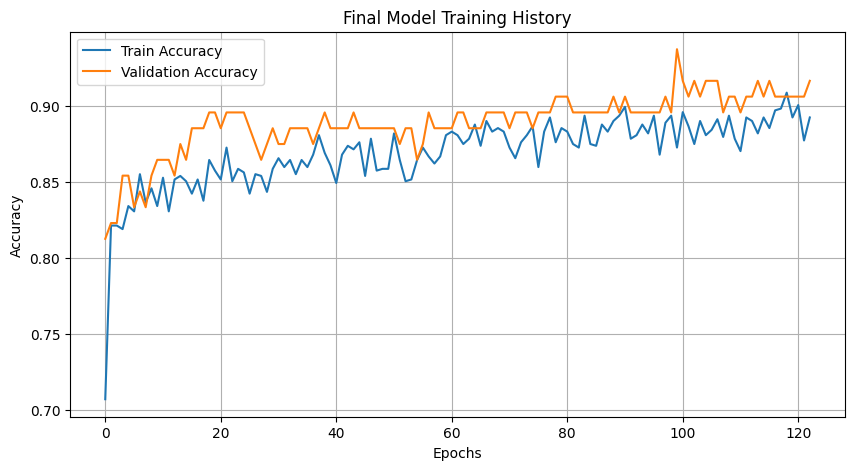

In [47]:
# Visualization 
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Final Model Training History")
plt.legend()
plt.grid()
plt.show()

In [49]:
# Training and test accuracy
train_acc = accuracy_score(y_train, best_xgb.predict(X_train))
test_acc = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9094
Testing Accuracy: 0.8824
